In [8]:
# FUNCTIONS & GLOBALS

# REPORT CORE VARIABLES
import pandas as pd
import numpy as np
from collections import namedtuple

# General Pandas settings
pd.options.display.max_rows = 500
pd.options.display.max_columns =500

# GLOBALS (messy as this was a scribbled script combined into throw-away functions)

# Covid-19 CSV data source
cv19_csv_source_deaths_global = r'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
cv19_csv_source_deaths_us = r'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
cv19_csv_source_cases_global = r'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
cv19_csv_source_cases_us = r'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'

#Population CSV data source
pop_csv_source_global = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\population-2019.csv'
pop_csv_source_us = r''

# REPORT GLOBALS
# Countries of interest
countries = []

# Starting date for charts etc.
start_date = pd.Timestamp(2020,3,1)

# Population to adjust all numbers to
rebase_population = 50E6

# Excel output file
excel_output_file = r''

# Folder to dump plot images to
plot_export_folder = r''

# Columns to rename in CV19 CSV file
cdf_rename_columns = {}

# Optional prefix before plot charts
plot_prefix = ""

# Whether to output files
output_files = False

# FUNCTIONS

# STANDARD REPORT SETTINGS
def set_eu_report_settings():
    global countries
    global start_date
    global rebase_population
    global excel_output_file
    global plot_export_folder
    global cdf_rename_columns
    global plot_prefix
    global output_files
    
    countries = ['France','Germany','Italy','Spain','Sweden','UK','US','New York','Belgium','Brazil','India','Austria']
    start_date = pd.Timestamp(2020,3,1)
    rebase_population = 50E6
    excel_output_file = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output.xlsx'
    plot_export_folder = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts'
    cdf_rename_columns = {'Province/State': 'State', 'Country/Region': 'Country'}
    plot_prefix = ""
    output_files = True
    
def set_us_report_settings():
    global countries
    global start_date
    global rebase_population
    global excel_output_file
    global plot_export_folder
    global cdf_rename_columns
    global plot_prefix
    global output_files
    countries = ['Texas','Tennessee','Alabama', 'Germany']
    start_date = pd.Timestamp(2020,3,14)
    rebase_population = 50E6
    excel_output_file = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output-us.xlsx'
    plot_export_folder = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts'
    plot_prefix = "us-"
    output_files = True
    
def set_scandi_report_settings():
    global countries
    global start_date
    global rebase_population
    global excel_output_file
    global plot_export_folder
    global cdf_rename_columns
    global plot_prefix
    global output_files
    countries = ['UK','Sweden','Norway','Denmark','Finland','Netherlands']
    # removed Iceland - small population leads to negative reporting
    start_date = pd.Timestamp(2020,3,14)
    rebase_population = 50E6
    excel_output_file = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output-scandi.xlsx'
    plot_export_folder = r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts'
    plot_prefix = "scandi-"
    output_files = True    
    
def load_global_cv19_deaths_dataframe():
    # LOAD & PROCESS COVID-19
    cdf = pd.read_csv(cv19_csv_source_deaths_global)
    print('Loaded Global CV19 Deaths Data')
        
    # Rename CV19 columns with illegal characters to something safe
    cdf.rename(columns={'Province/State': 'State', 'Country/Region': 'Country'}, inplace=True)

    # Rename long country names
    cdf = cdf.replace({'United Kingdom':'UK'})

    # keep only the State=NaN rows to make Country unique
    cdf = cdf[cdf['State'].isin([np.nan])]

    # Drop unnecesary columns
    cdf = cdf.drop(['State','Lat','Long'], axis='columns')
    
    # Group by state (ensure no duplicates)
    cdf = cdf.groupby('Country').sum()
   
    return cdf

def load_global_cv19_cases_dataframe():
    # LOAD & PROCESS COVID-19
    cdf = pd.read_csv(cv19_csv_source_cases_global)
    print('Loaded Global CV19 Cases Data')
        
    # Rename CV19 columns with illegal characters to something safe
    cdf.rename(columns={'Province/State': 'State', 'Country/Region': 'Country'}, inplace=True)

    # Rename long country names
    cdf = cdf.replace({'United Kingdom':'UK'})

    # keep only the State=NaN rows to make Country unique
    cdf = cdf[cdf['State'].isin([np.nan])]

    # Drop unnecesary columns
    cdf = cdf.drop(['State','Lat','Long'], axis='columns')
    
    # Group by state (ensure no duplicates)
    cdf = cdf.groupby('Country').sum()
   
    return cdf

def load_us_cv19_deaths_dataframe():
    cdf = pd.read_csv(cv19_csv_source_deaths_us)
    print('Loaded US CV19 Deaths Data')
    
    cdf.rename(columns={'Province_State': 'State', 'Country_Region': 'Country'}, inplace=True)

    # Rename ambiguous state names
    cdf = cdf.replace({'Georgia':'Georgia(US)'})
    
    # Drop "Unassigned" - these create negative deaths => zombie apocalypse
    cdf = cdf[cdf.Admin2 != "Unassigned"]

    # Drop unnecesary columns
    cdf = cdf.drop(['UID','iso2','iso3','FIPS','Admin2','code3','Lat','Long_','Population'], axis='columns')

    # Group by state (ensure no duplicates)
    cdf = cdf.groupby('State').sum()
    
    # Rename State as Country so stacks properly
    cdf = cdf.rename_axis(index='Country')

    # Messy - Diamond Princess appears in both global and US lists
    cdf = cdf.drop(['Diamond Princess'], axis=0)

    return cdf

def load_us_cv19_cases_dataframe():
    cdf = pd.read_csv(cv19_csv_source_cases_us)
    print('Loaded US CV19 Cases Data')
    
    cdf.rename(columns={'Province_State': 'State', 'Country_Region': 'Country'}, inplace=True)

    # Rename ambiguous state names
    cdf = cdf.replace({'Georgia':'Georgia(US)'})
    
    # Drop "Unassigned" - these create negative deaths => zombie apocalypse
    cdf = cdf[cdf.Admin2 != "Unassigned"]

    # Drop unnecesary columns
    cdf = cdf.drop(['UID','iso2','iso3','FIPS','Admin2','code3','Lat','Long_'], axis='columns')

    # Group by state (ensure no duplicates)
    cdf = cdf.groupby('State').sum()
    
    # Rename State as Country so stacks properly
    cdf = cdf.rename_axis(index='Country')

    # Messy - Diamond Princess appears in both global and US lists
    cdf = cdf.drop(['Diamond Princess'], axis=0)

    return cdf

def load_global_pop_dataframe():
    pdf = pd.read_csv(pop_csv_source_global)
    print('Loaded Global Population Data')

    # Rename country names in population to allow later join
    pdf = pdf.replace({'United States of America':'US', 'United Kingdom':'UK'})

    # Rename columns for consistency with CV19 data
    pdf = pdf.rename(columns={'Location':'Country'})

    # Only keep relevant columns
    pdf = pdf[['Country','PopTotal']]

    # Group by country (ensure no duplicates)
    pdf = pdf.groupby('Country').sum()

    # Convert populations to correct numbers (source is in 1000's)
    pdf[['PopTotal']] = pdf[['PopTotal']] * 1000

    return pdf

def load_us_pop_dataframe():
    # Basic US data is in the CV19 data file
    pdf = pd.read_csv(cv19_csv_source_deaths_us)
    print("Loaded US Population Data")

    # Rename columns to make consistent
    pdf.rename(columns={'Province_State': 'State', 'Country_Region': 'Country', 'Population':'PopTotal'}, inplace=True)

    # Rename ambiguous state names
    pdf = pdf.replace({'Georgia':'Georgia(US)'})

    # Only keep relevant columns
    pdf = pdf[['State','PopTotal']]

    # Group by state (ensure no duplicates)
    pdf = pdf.groupby('State').sum()
    
    # Rename State as Country so stacks properly
    pdf = pdf.rename_axis(index='Country')

    # Messy - Diamond Princess appears in both global and US lists
    pdf = pdf.drop(['Diamond Princess', 'American Samoa', 'Guam', 'Northern Mariana Islands', 'Puerto Rico'], axis=0)

    return pdf

def list_countries():
    cdf = load_global_cv19_dataframe()
    cdf = cdf.append(load_us_cv19_dataframe(), sort=True, verify_integrity=True)
    return pd.DataFrame(cdf.index)

def load_cv19_deaths_dataframe():
    cdf = load_global_cv19_deaths_dataframe()
    cdf = cdf.append(load_us_cv19_deaths_dataframe(), sort=True, verify_integrity=True)    
    return cdf

def load_cv19_cases_dataframe():
    cdf = load_global_cv19_cases_dataframe()
    cdf = cdf.append(load_us_cv19_cases_dataframe(), sort=True, verify_integrity=True)    
    return cdf

def load_pop_dataframe():
    pdf = load_global_pop_dataframe()
    pdf = pdf.append(load_us_pop_dataframe(), sort=True, verify_integrity=True)
    return pdf

# Named tuple for return of data
HospitalData = namedtuple('HospitalData', 'patients,ventilators,deaths_deathdate,deaths_publishdate,stacked')

def load_hospital_dataframe():
    df_admissions = pd.read_csv('https://api.coronavirus.data.gov.uk/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newAdmissions%22:%22newAdmissions%22,%22cumAdmissions%22:%22cumAdmissions%22%7D&format=csv')
    df_patients = pd.read_csv('https://api.coronavirus.data.gov.uk/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22hospitalCases%22:%22hospitalCases%22%7D&format=csv')
    df_ventilators = pd.read_csv('https://api.coronavirus.data.gov.uk/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22covidOccupiedMVBeds%22:%22covidOccupiedMVBeds%22%7D&format=csv')
    df_deaths_deathdate = pd.read_csv('https://api.coronavirus.data.gov.uk/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newDeaths28DaysByDeathDate%22:%22newDeaths28DaysByDeathDate%22,%22cumDeaths28DaysByDeathDate%22:%22cumDeaths28DaysByDeathDate%22%7D&format=csv')
    df_deaths_publishdate = pd.read_csv('https://api.coronavirus.data.gov.uk/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newDeaths28DaysByPublishDate%22:%22newDeaths28DaysByPublishDate%22,%22cumDeaths28DaysByPublishDate%22:%22cumDeaths28DaysByPublishDate%22%7D&format=csv')
    df_vaccincations = pd.read_csv('https://coronavirus.data.gov.uk/api/v1/data?filters=areaType=overview&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newPeopleVaccinatedFirstDoseByPublishDate%22:%22newPeopleVaccinatedFirstDoseByPublishDate%22,%22newPeopleVaccinatedSecondDoseByPublishDate%22:%22newPeopleVaccinatedSecondDoseByPublishDate%22,%22cumPeopleVaccinatedFirstDoseByPublishDate%22:%22cumPeopleVaccinatedFirstDoseByPublishDate%22,%22cumPeopleVaccinatedSecondDoseByPublishDate%22:%22cumPeopleVaccinatedSecondDoseByPublishDate%22%7D&format=csv')

    # Add a 'Type' column so they can be stacked
    df_admissions['Type'] = 'HospitalAdmissions'
    df_patients['Type'] = 'OccupiedBeds'
    df_ventilators['Type'] = 'OccupiedMVBeds'
    df_deaths_deathdate['Type'] = 'Deaths28DaysByDeathDate'
    df_deaths_publishdate['Type'] = 'Deaths28DaysByPublishDate'
    df_vaccinations_first_new = df_vaccincations.copy()
    df_vaccinations_first_new['Type'] = "VaccinationsFirstDoseNew"
    df_vaccinations_first_cum = df_vaccincations.copy()
    df_vaccinations_first_cum['Type'] = "VaccinationsFirstDoseCum"
    df_vaccinations_second_new = df_vaccincations.copy()
    df_vaccinations_second_new['Type'] = "VaccinationsSecondDoseNew"
    df_vaccinations_second_cum = df_vaccincations.copy()
    df_vaccinations_second_cum['Type'] = "VaccinationsSecondDoseCum"

    # rename key columns so they can be stacked and remove unnecessary ones
    df_admissions_std = df_admissions.rename(columns={'newAdmissions':'count'})
    df_admissions_std = df_admissions_std.drop('cumAdmissions', axis='columns')
    df_patients_std = df_patients.rename(columns={'hospitalCases':'count'})
    df_ventilators_std = df_ventilators.rename(columns={'covidOccupiedMVBeds':'count'})
    df_deaths_deathdate_std = df_deaths_deathdate.rename(columns={'newDeaths28DaysByDeathDate':'count'})
    df_deaths_deathdate_std = df_deaths_deathdate_std.drop('cumDeaths28DaysByDeathDate', axis='columns')
    df_deaths_publishdate_std = df_deaths_publishdate.rename(columns={'newDeaths28DaysByPublishDate':'count'})
    df_deaths_publishdate_std = df_deaths_publishdate_std.drop('cumDeaths28DaysByPublishDate', axis='columns')
    df_vaccinations_first_new_std = df_vaccinations_first_new.rename(columns={'newPeopleVaccinatedFirstDoseByPublishDate':'count'})
    df_vaccinations_first_new_std = df_vaccinations_first_new_std.drop(['newPeopleVaccinatedSecondDoseByPublishDate', 
                                                                        'cumPeopleVaccinatedFirstDoseByPublishDate', 
                                                                        'cumPeopleVaccinatedSecondDoseByPublishDate'], axis='columns')
    df_vaccinations_first_cum_std = df_vaccinations_first_cum.rename(columns={'cumPeopleVaccinatedFirstDoseByPublishDate':'count'})
    df_vaccinations_first_cum_std = df_vaccinations_first_cum_std.drop(['newPeopleVaccinatedFirstDoseByPublishDate', 
                                                                        'newPeopleVaccinatedSecondDoseByPublishDate', 
                                                                        'cumPeopleVaccinatedSecondDoseByPublishDate'], axis='columns')
    df_vaccinations_second_new_std = df_vaccinations_second_new.rename(columns={'newPeopleVaccinatedSecondDoseByPublishDate':'count'})
    df_vaccinations_second_new_std = df_vaccinations_second_new_std.drop(['newPeopleVaccinatedFirstDoseByPublishDate', 
                                                                          'cumPeopleVaccinatedFirstDoseByPublishDate', 
                                                                          'cumPeopleVaccinatedSecondDoseByPublishDate'], axis='columns')
    df_vaccinations_second_cum_std = df_vaccinations_second_cum.rename(columns={'cumPeopleVaccinatedSecondDoseByPublishDate':'count'})
    df_vaccinations_second_cum_std = df_vaccinations_second_cum_std.drop(['newPeopleVaccinatedSecondDoseByPublishDate', 
                                                                          'cumPeopleVaccinatedFirstDoseByPublishDate', 
                                                                          'newPeopleVaccinatedFirstDoseByPublishDate'], axis='columns')    

    # stack them all
    df_stacked = df_admissions_std.append(
        df_patients_std).append(
        df_ventilators_std).append(
        df_deaths_deathdate_std).append(
        df_deaths_publishdate_std).append(
        df_vaccinations_first_new_std).append(
        df_vaccinations_first_cum_std).append(
        df_vaccinations_second_new_std).append(
        df_vaccinations_second_cum_std)
    df_stacked = df_stacked.set_index('date')
    df_stacked = df_stacked.sort_values(['areaName','date'])
    
    print('Loaded UK hospital data')
    return HospitalData(df_patients, df_ventilators, df_deaths_deathdate, df_deaths_publishdate, df_stacked)

# Named tuple for data frames
DFs = namedtuple('DFs', 'cdfd,cdfc,pdf,hdf')

def load_dataframes():
    cdfd = load_cv19_deaths_dataframe()
    cdfc = load_cv19_cases_dataframe()
    pdf = load_pop_dataframe()
    hdf = load_hospital_dataframe()
    return DFs(cdfd, cdfc, pdf, hdf)

# Named tuple for return of data
CVData = namedtuple('CVData', 'cdf_abssum,cdf_adjsum,cdf_absdaily,cdf_adjdaily,cdf_adjdaily_mavg')

def process_dataframes(dfs, type='deaths'):
    # CORE DATA PROCESSING
    if type == 'deaths':
        cdf = dfs.cdfd
    elif type == 'cases':
        cdf = dfs.cdfc
    else:
        raise RuntimeError('Invalid dataframe type "{}"'.format(type))

    # Filter to countries of interest
    if countries != []:
        cdf = cdf.loc[countries]

    # Transpose to time series
    cdf = cdf.T

    # Rename column axis
    cdf = cdf.rename_axis(index='Country')

    # Rename row axis
    cdf = cdf.rename_axis(index='Date', axis=1)

    # Convert index strings into dates
    cdf = cdf.set_index(pd.to_datetime(cdf.index, format='%m/%d/%y'))

    # Ensure in proper date order
    cdf = cdf.sort_index()

    # Drop all rows before start date
    cdf = cdf[cdf.index >= start_date]

    print('Covid-19 data imported & normalized')

    # LOAD & PROCESS POPULATION DATA
    pdf = dfs.pdf

    # Filter to countries of interest
    if countries != []:
        pdf = pdf.loc[countries]

    # Calculate population multiplier column (factor to normalise into standard population)
    pdf[['PopMultiplier']] = 1/(pdf[['PopTotal']]/rebase_population)

    print('Population data imported & normalized')

    # DATA CHECKS

    # Check 1:1 mapping between data sets (note different axes)
    assert cdf.columns.size == pdf.index.size, 'Data-sets have different country sets - maybe country name mismatch? covid_data:{}, pop_data:{}'.format(cdf.columns.size, pdf.index.size)
    print('Data checks pass')

    # CALCULATE
    # Generate the output data frames for all charts

    # Absolute and pop adjusted total deaths
    cdf_abssum = cdf
    cdf_adjsum = cdf_abssum.multiply(pdf['PopMultiplier'])

    # Absolute and pop adjusted daily adjusted deaths
    cdf_absdaily = cdf_abssum.diff()
    cdf_adjdaily = cdf_absdaily.multiply(pdf['PopMultiplier'])
    cdf_adjdaily_mavg = cdf_adjdaily.rolling(window=7).mean()
    print('Calculated dataframes ready')
    
    return CVData(cdf_abssum, cdf_adjsum, cdf_absdaily, cdf_adjdaily, cdf_adjdaily_mavg)

# EXPORT
# Dump to a single Excel sheet with multiple worksheets
def output_data_files(cvdata_deaths, cvdata_cases, hospital_data):
    if output_files is True:
        with pd.ExcelWriter(excel_output_file, date_format='YYYY-MM-DD') as xl:
                cvdata_deaths.cdf_abssum.to_excel(xl, sheet_name='Abs Sum Deaths')
                cvdata_deaths.cdf_adjsum.to_excel(xl, sheet_name='Adj Sum Deaths')
                cvdata_deaths.cdf_absdaily.to_excel(xl, sheet_name='Abs Daily Deaths')
                cvdata_deaths.cdf_adjdaily.to_excel(xl, sheet_name='Adj Daily Deaths')
                cvdata_deaths.cdf_adjdaily_mavg.to_excel(xl, sheet_name='Adj Daily Deaths (mavg7)')

                cvdata_cases.cdf_abssum.to_excel(xl, sheet_name='Abs Sum Cases')
                cvdata_cases.cdf_adjsum.to_excel(xl, sheet_name='Adj Sum Cases')
                cvdata_cases.cdf_absdaily.to_excel(xl, sheet_name='Abs Daily Cases')
                cvdata_cases.cdf_adjdaily.to_excel(xl, sheet_name='Adj Daily Cases')
                cvdata_cases.cdf_adjdaily_mavg.to_excel(xl, sheet_name='Adj Daily Cases (mavg7)')
                
                hospital_data.stacked.to_excel(xl, sheet_name="UK_Healthcare")
                
        print('Excel output file written : {}'.format(excel_output_file))
    else:
        print('Excel output disabled')
        
def plot_and_save_charts(dfsd, dfsc):
    # PLOT & SAVE THE CHARTS
    
    plot_and_save_chart(dfsd.cdf_abssum, 'cumulative-deaths.png', 'Absolute cumulative deaths')
    plot_and_save_chart(dfsd.cdf_adjsum, 'pop-adjusted-cumulative-deaths.png','Pop adjusted cumulative deaths')
    plot_and_save_chart(dfsd.cdf_absdaily, 'absolute-daily-deaths.png','Absolute daily deaths')
    plot_and_save_chart(dfsd.cdf_adjdaily, 'pop-adjusted-daily-deaths.png','Pop adjusted daily deaths')
    plot_and_save_chart(dfsd.cdf_adjdaily_mavg, 'pop-adjusted-daily-deaths-mavg7.png','Pop adjusted daily deaths (mavg=7)')

    plot_and_save_chart(dfsc.cdf_abssum, 'cumulative-cases.png', 'Absolute cumulative cases')
    plot_and_save_chart(dfsc.cdf_adjsum, 'pop-adjusted-cumulative-cases.png','Pop adjusted cumulative cases')
    plot_and_save_chart(dfsc.cdf_absdaily, 'absolute-daily-cases.png','Absolute daily cases')
    plot_and_save_chart(dfsc.cdf_adjdaily, 'pop-adjusted-daily-cases.png','Pop adjusted daily cases')
    plot_and_save_chart(dfsc.cdf_adjdaily_mavg, 'pop-adjusted-daily-cases-mavg7.png','Pop adjusted daily cases (mavg=7)')

    if output_files is False:
        print('File output disabled')
        
def plot_and_save_chart(df, filename, title):
    # create a plot from supplied data and save it (if saving enabled)
    import matplotlib.pyplot as plt
    import os
    filepath = os.path.join(plot_export_folder, plot_prefix + filename)
    df.plot(title=title)
    plt.show()
    plt.close()
    if output_files is True:
        plt.savefig(filepath)
        print('{} -> {}'.format(filename, filepath))


def do_everything(dfs):
    # Run all processes based on set config
    dfsd = process_dataframes(dfs, 'deaths')
    dfsc = process_dataframes(dfs, 'cases')
    output_data_files(dfsd, dfsc, dfs.hdf)
    plot_and_save_charts(dfsd, dfsc)

def copy_folder_contents(src, dest):
    import os
    import shutil
    src_files = os.listdir(src)
    for file_name in src_files:
        full_file_name = os.path.join(src, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dest)
            print('Copied {} to {}'.format(full_file_name, dest))

def copy_files_to_public():
    copy_folder_contents(r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts', r'C:\Users\Jon Sturley\OneDrive\Public\covid-19')
    copy_folder_contents(r'C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data', r'C:\Users\Jon Sturley\OneDrive\Public\covid-19')
   
'Functions loaded'

'Functions loaded'

Loaded Global CV19 Deaths Data
Loaded US CV19 Deaths Data
Loaded Global CV19 Cases Data
Loaded US CV19 Cases Data
Loaded Global Population Data
Loaded US Population Data
Loaded UK hospital data
Covid-19 data imported & normalized
Population data imported & normalized
Data checks pass
Calculated dataframes ready
Covid-19 data imported & normalized
Population data imported & normalized
Data checks pass
Calculated dataframes ready
Excel output file written : C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output.xlsx


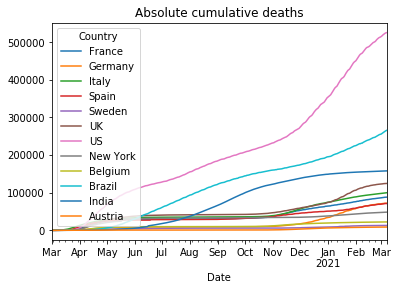

cumulative-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\cumulative-deaths.png


<Figure size 432x288 with 0 Axes>

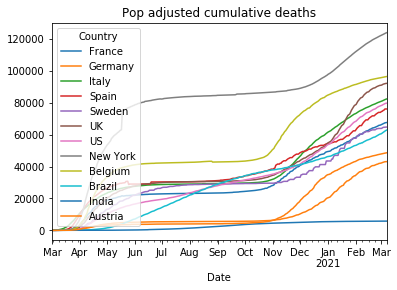

pop-adjusted-cumulative-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\pop-adjusted-cumulative-deaths.png


<Figure size 432x288 with 0 Axes>

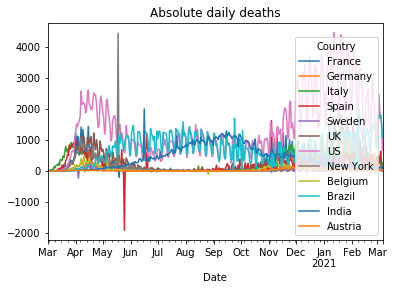

absolute-daily-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\absolute-daily-deaths.png


<Figure size 432x288 with 0 Axes>

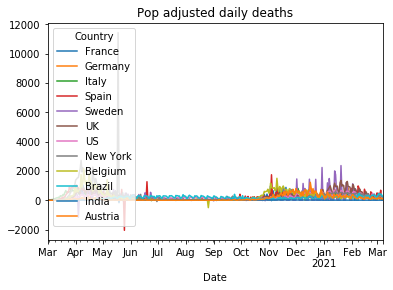

pop-adjusted-daily-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\pop-adjusted-daily-deaths.png


<Figure size 432x288 with 0 Axes>

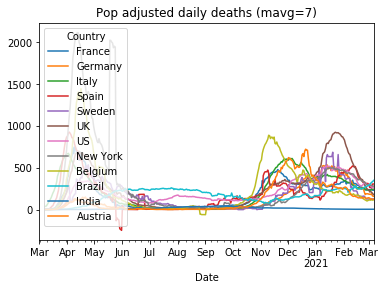

pop-adjusted-daily-deaths-mavg7.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\pop-adjusted-daily-deaths-mavg7.png


<Figure size 432x288 with 0 Axes>

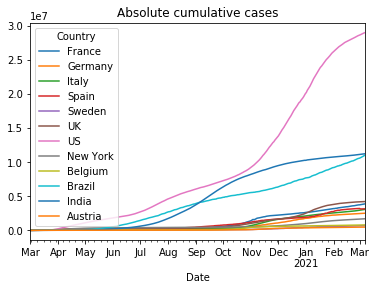

cumulative-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\cumulative-cases.png


<Figure size 432x288 with 0 Axes>

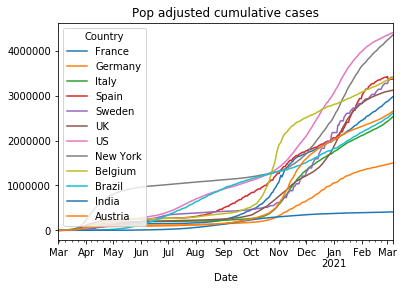

pop-adjusted-cumulative-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\pop-adjusted-cumulative-cases.png


<Figure size 432x288 with 0 Axes>

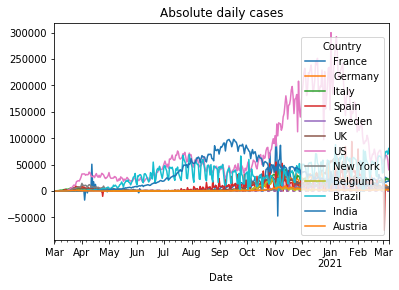

absolute-daily-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\absolute-daily-cases.png


<Figure size 432x288 with 0 Axes>

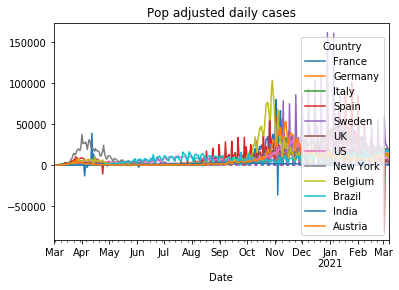

pop-adjusted-daily-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\pop-adjusted-daily-cases.png


<Figure size 432x288 with 0 Axes>

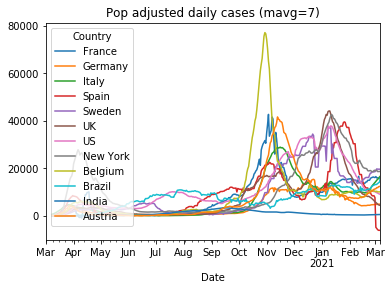

pop-adjusted-daily-cases-mavg7.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\pop-adjusted-daily-cases-mavg7.png
Covid-19 data imported & normalized
Population data imported & normalized
Data checks pass
Calculated dataframes ready
Covid-19 data imported & normalized
Population data imported & normalized
Data checks pass
Calculated dataframes ready
Excel output file written : C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output-us.xlsx


<Figure size 432x288 with 0 Axes>

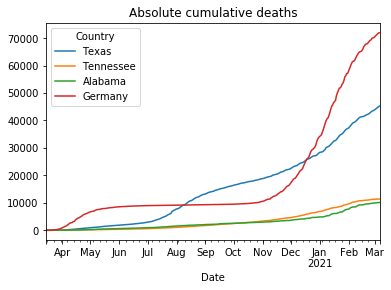

cumulative-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-cumulative-deaths.png


<Figure size 432x288 with 0 Axes>

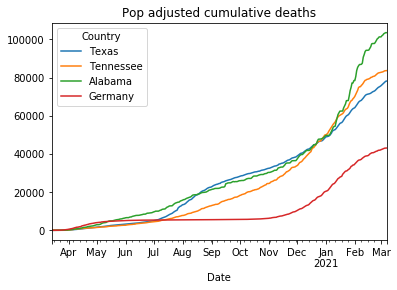

pop-adjusted-cumulative-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-pop-adjusted-cumulative-deaths.png


<Figure size 432x288 with 0 Axes>

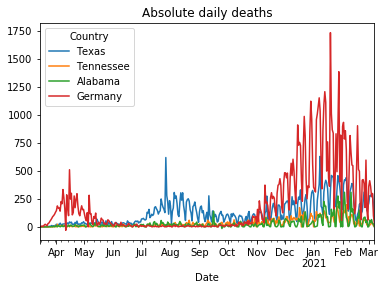

absolute-daily-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-absolute-daily-deaths.png


<Figure size 432x288 with 0 Axes>

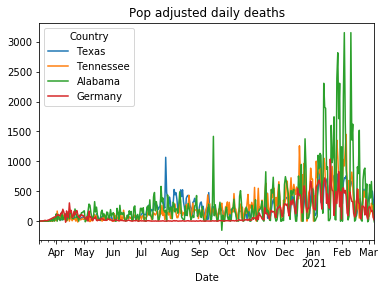

pop-adjusted-daily-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-pop-adjusted-daily-deaths.png


<Figure size 432x288 with 0 Axes>

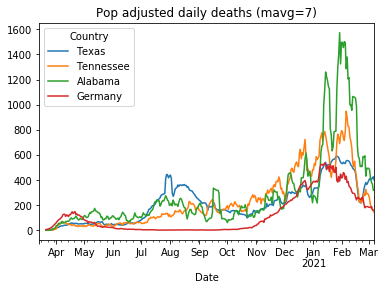

pop-adjusted-daily-deaths-mavg7.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-pop-adjusted-daily-deaths-mavg7.png


<Figure size 432x288 with 0 Axes>

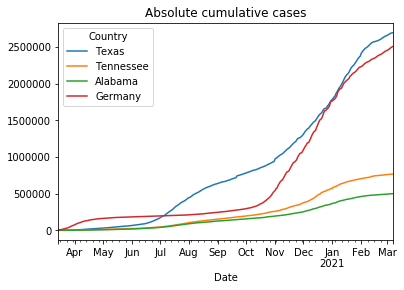

cumulative-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-cumulative-cases.png


<Figure size 432x288 with 0 Axes>

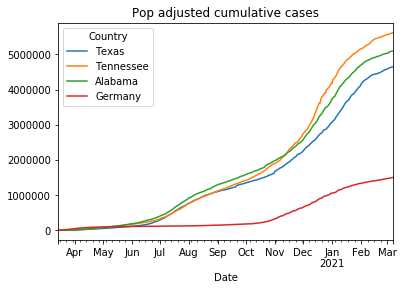

pop-adjusted-cumulative-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-pop-adjusted-cumulative-cases.png


<Figure size 432x288 with 0 Axes>

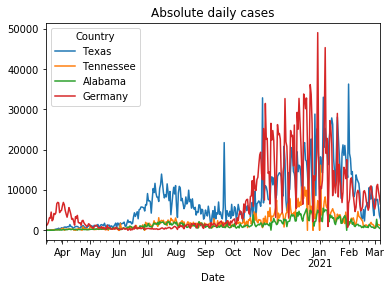

absolute-daily-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-absolute-daily-cases.png


<Figure size 432x288 with 0 Axes>

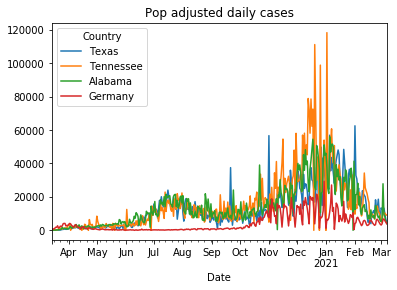

pop-adjusted-daily-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-pop-adjusted-daily-cases.png


<Figure size 432x288 with 0 Axes>

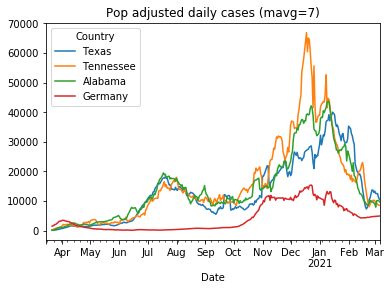

pop-adjusted-daily-cases-mavg7.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-pop-adjusted-daily-cases-mavg7.png
Covid-19 data imported & normalized
Population data imported & normalized
Data checks pass
Calculated dataframes ready
Covid-19 data imported & normalized
Population data imported & normalized
Data checks pass
Calculated dataframes ready
Excel output file written : C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output-scandi.xlsx


<Figure size 432x288 with 0 Axes>

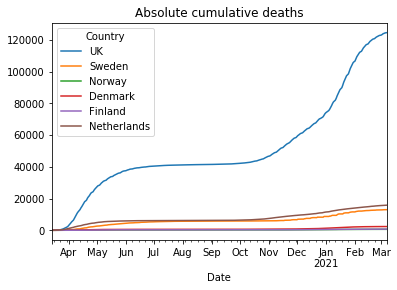

cumulative-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-cumulative-deaths.png


<Figure size 432x288 with 0 Axes>

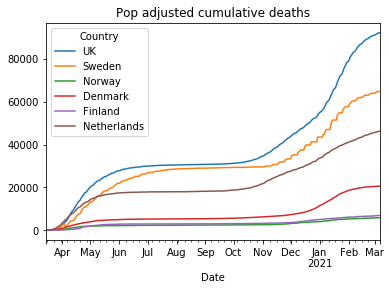

pop-adjusted-cumulative-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-pop-adjusted-cumulative-deaths.png


<Figure size 432x288 with 0 Axes>

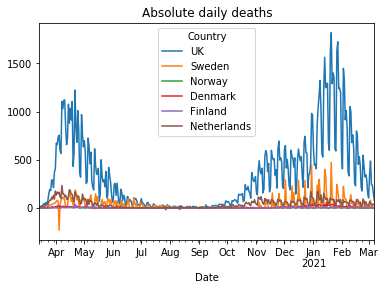

absolute-daily-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-absolute-daily-deaths.png


<Figure size 432x288 with 0 Axes>

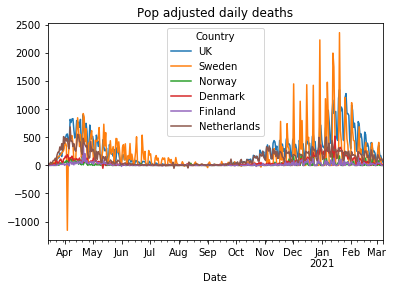

pop-adjusted-daily-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-pop-adjusted-daily-deaths.png


<Figure size 432x288 with 0 Axes>

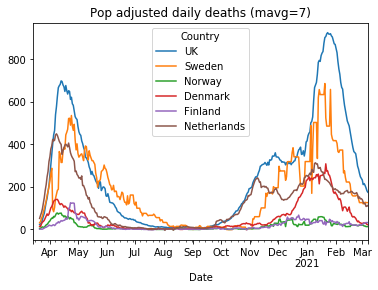

pop-adjusted-daily-deaths-mavg7.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-pop-adjusted-daily-deaths-mavg7.png


<Figure size 432x288 with 0 Axes>

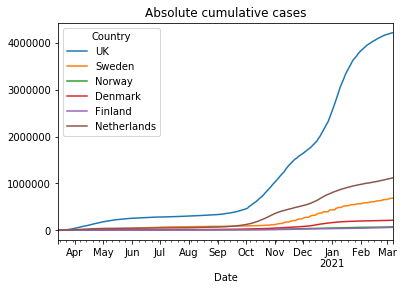

cumulative-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-cumulative-cases.png


<Figure size 432x288 with 0 Axes>

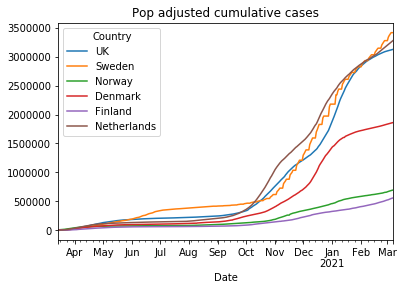

pop-adjusted-cumulative-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-pop-adjusted-cumulative-cases.png


<Figure size 432x288 with 0 Axes>

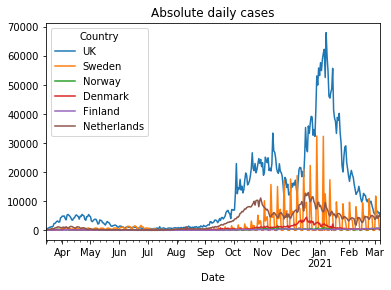

absolute-daily-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-absolute-daily-cases.png


<Figure size 432x288 with 0 Axes>

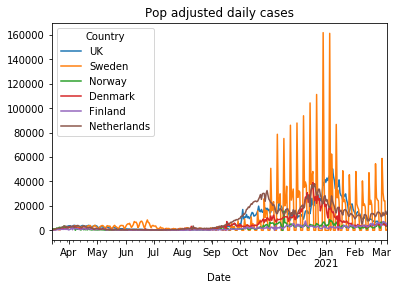

pop-adjusted-daily-cases.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-pop-adjusted-daily-cases.png


<Figure size 432x288 with 0 Axes>

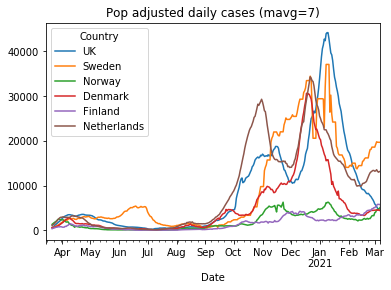

pop-adjusted-daily-cases-mavg7.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\scandi-pop-adjusted-daily-cases-mavg7.png


<Figure size 432x288 with 0 Axes>

In [9]:
# Run everything
dfs = load_dataframes()

set_eu_report_settings()
do_everything(dfs)

set_us_report_settings()
do_everything(dfs)

set_scandi_report_settings()
do_everything(dfs)

#copy_files_to_public()

In [15]:
copy_files_to_public()

Copied C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\absolute-daily-deaths.png to C:\Users\Jon Sturley\OneDrive\Public\covid-19
Copied C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\covid-19-country-adjusted-deaths-mavg.png to C:\Users\Jon Sturley\OneDrive\Public\covid-19
Copied C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\covid-19-country-adjusted-deaths-poly.png to C:\Users\Jon Sturley\OneDrive\Public\covid-19
Copied C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\covid-19-country-adjusted-deaths-rebased.png to C:\Users\Jon Sturley\OneDrive\Public\covid-19
Copied C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\covid-19-country-adjusted-deaths.png to C:\Users\Jon Sturley\OneDrive\Public\covid-19
Copied C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\covid-19-increased-mortality-by-age-weekly-annualized.png to C:\Users\Jon Sturley\OneDrive\Public\covid-19
Copied C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\c

Loaded Global CV19 Data
Loaded US CV19 Data
Loaded Global Population Data
Loaded US Population Data
Covid-19 data imported & normalized
Population data imported & normalized
Data checks pass
Calculated dataframes ready
Excel output file written : C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\data\covid-19-pandas-output-us.xlsx
cumulative-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-cumulative-deaths.png
pop-adjusted-cumulative-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-pop-adjusted-cumulative-deaths.png
absolute-daily-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-absolute-daily-deaths.png
pop-adjusted-daily-deaths.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-pop-adjusted-daily-deaths.png
pop-adjusted-daily-deaths-mavg5.png -> C:\Users\Jon Sturley\OneDrive\Code\GitHub\covid-19\charts\us-pop-adjusted-daily-deaths-mavg5.png


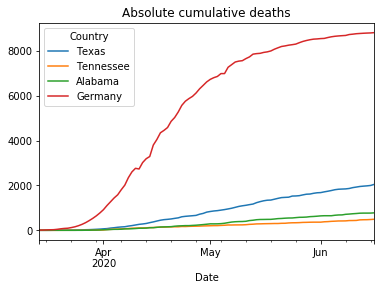

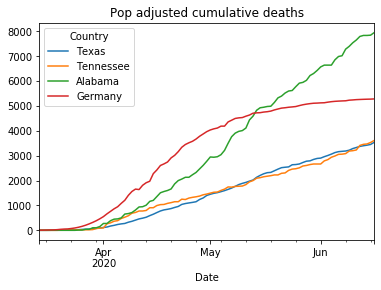

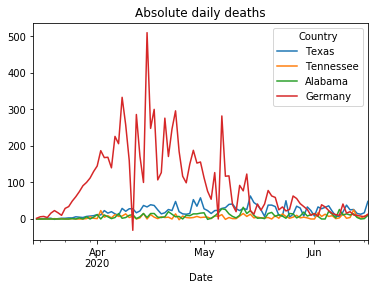

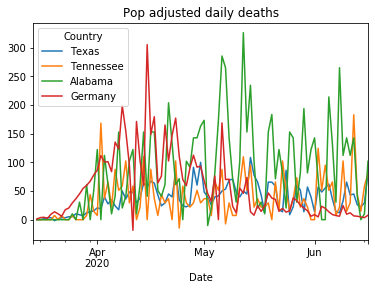

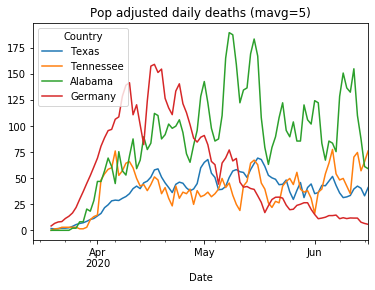

In [12]:
# Run everything
dfs = load_dataframes()

set_us_report_settings()
do_everything(dfs)

In [85]:
df = load_hospital_dataframe()
df.deaths_publishdate

#pd.read_csv('https://api.coronavirus.data.gov.uk/v1/data?filters=areaType=nation&structure=%7B%22areaType%22:%22areaType%22,%22areaName%22:%22areaName%22,%22areaCode%22:%22areaCode%22,%22date%22:%22date%22,%22newDeaths28DaysByPublishDate%22:%22newDeaths28DaysByPublishDate%22,%22cumDeaths28DaysByPublishDate%22:%22cumDeaths28DaysByPublishDate%22%7D&format=csv')

Loaded UK hospital data


,areaType,areaName,areaCode,date,newDeaths28DaysByPublishDate,cumDeaths28DaysByPublishDate,Type
0,nation,England,E92000001,2020-10-08,70,37823.0,Deaths28DaysByPublishDate
1,nation,England,E92000001,2020-10-07,65,37753.0,Deaths28DaysByPublishDate
2,nation,England,E92000001,2020-10-06,63,37688.0,Deaths28DaysByPublishDate
3,nation,England,E92000001,2020-10-05,19,37625.0,Deaths28DaysByPublishDate
4,nation,England,E92000001,2020-10-04,32,37606.0,Deaths28DaysByPublishDate
...,...,...,...,...,...,...,...
995,nation,Wales,W92000004,2020-05-06,21,1044.0,Deaths28DaysByPublishDate
996,nation,Wales,W92000004,2020-05-05,26,1023.0,Deaths28DaysByPublishDate
997,nation,Wales,W92000004,2020-05-04,14,997.0,Deaths28DaysByPublishDate
998,nation,Wales,W92000004,2020-05-03,14,983.0,Deaths28DaysByPublishDate


Todo:
    - Improve chart quality
        - Consistent colors
        - Grid lines
        - Larger
    - Set up static web site on AWS S3
    - Add function to upload to S3 bucket
    - Schedule job to run Python every day on AWS